## Identify presence of human in pictures
- The dataset consists of a collection of cctv footage (images) from various source.
- Labels: 0 (no presence), 1 (presence)

### Import libraries

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, utils, models
from torchvision.datasets import ImageFolder

In [3]:
# Define the transform
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

data_transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalise
])

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise
])

In [4]:
main_dir = 'C:\\Users\\YanMin\\Desktop\\Dev\\Personal\\human-identifier-real-time\\dataset'

In [5]:
human_dataset = ImageFolder(main_dir, transform=data_transforms_train)

# Split into train, test and val Datasets
train_size = int(len(human_dataset) * 0.7)
test_size = int(len(human_dataset) * 0.2)
val_size = len(human_dataset) - train_size - test_size

train, test, val = random_split(human_dataset, [train_size, test_size, val_size])

test.dataset.transform = data_transforms
val.dataset.transform = data_transforms

# Create DataLoaders
train_loader = DataLoader(train, batch_size=4, shuffle=True)
test_loader = DataLoader(test, batch_size=4, shuffle=True)
val_loader = DataLoader(val, batch_size=4, shuffle=False)

dataloaders = {
    'train': train_loader,
    'test': test_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train),
    'test': len(test),
    'val': len(val)
}

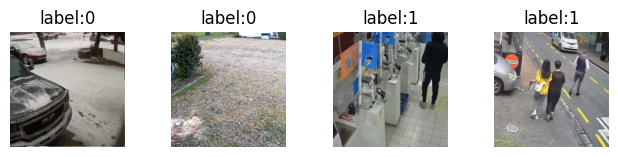

In [6]:
# Plot example
fig = plt.figure()

mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

for i, (img, label) in enumerate(train_loader):
    image = img[0].clone()

    # unnormalize for nice plot
    image = image * std + mean
    
    image = image.clamp(0, 1)

    # Plot images
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'label:{label[0].item()}')
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0))
    if (i == 3):
        plt.show()
        break

## Building model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temp directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_prarams.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the param gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model

## Finetuning the model

In [9]:
# Load the pretrained model and reset the final layer

model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')

model_ft.classifier[1] = nn.Linear(model_ft.last_channel, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # For classification

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler for better convergence
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.5331 Acc: 0.7717
test Loss: 0.2947 Acc: 0.8967

Epoch 1/24
----------
train Loss: 0.3569 Acc: 0.8634
test Loss: 0.2646 Acc: 0.8913

Epoch 2/24
----------
train Loss: 0.2795 Acc: 0.8960
test Loss: 0.2308 Acc: 0.9239

Epoch 3/24
----------
train Loss: 0.2368 Acc: 0.9255
test Loss: 0.2075 Acc: 0.9185

Epoch 4/24
----------
train Loss: 0.1707 Acc: 0.9394
test Loss: 0.2296 Acc: 0.9022

Epoch 5/24
----------
train Loss: 0.2969 Acc: 0.9068
test Loss: 0.2346 Acc: 0.8967

Epoch 6/24
----------
train Loss: 0.2046 Acc: 0.9425
test Loss: 0.3125 Acc: 0.8478

Epoch 7/24
----------
train Loss: 0.1793 Acc: 0.9425
test Loss: 0.1889 Acc: 0.9293

Epoch 8/24
----------
train Loss: 0.1655 Acc: 0.9534
test Loss: 0.1760 Acc: 0.9293

Epoch 9/24
----------
train Loss: 0.1039 Acc: 0.9752
test Loss: 0.1783 Acc: 0.9239

Epoch 10/24
----------
train Loss: 0.1088 Acc: 0.9783
test Loss: 0.1749 Acc: 0.9293

Epoch 11/24
----------
train Loss: 0.1326 Acc: 0.9705
test Loss: 0.1827 Acc

## Check accuracy on validation set

In [32]:
def validation_pred(model, val):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / dataset_sizes['val']
    acc = running_corrects.double() / dataset_sizes['val']

    print(f'Loss: {loss:.4f} Acc: {acc:.4f}')

In [33]:
validation_pred(model_ft, val_loader)

Loss: 0.2965 Acc: 0.9355


## Visualise with a custom image

In [58]:
def visualize_model_predictions(model, img_path, class_names):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert('RGB')
    img = data_transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    unnorm_img = img.cpu().squeeze(0).clone()
    unnorm_img = unnorm_img * std + mean
    unnorm_img = unnorm_img.clamp(0, 1)

    ax = plt.subplot(2, 2, 1)
    ax.axis('off')
    ax.set_title(f'Predicted: {class_names[preds[0]]}')
    plt.imshow(unnorm_img.permute(1, 2, 0))
        
    model.train(mode=was_training)

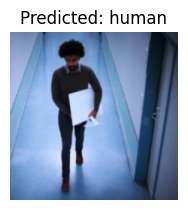

In [67]:
class_names = ['no human', 'human']
visualize_model_predictions(
    model_ft,
    img_path='../custom/custom_with_person.jpg',
    class_names=class_names
)

plt.ioff()
plt.show()